In [1]:
# employee retention
# goal predict when an employee will leave. find the main factors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, average_precision_score

In [2]:
# EDA and data pre-processing
df = pd.read_csv("employee_retention_data.csv")
df.head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [3]:
df.info()
df.describe()
# employee id  float -> int
# dept object -> categorical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  24702 non-null  float64
 1   company_id   24702 non-null  int64  
 2   dept         24702 non-null  object 
 3   seniority    24702 non-null  int64  
 4   salary       24702 non-null  float64
 5   join_date    24702 non-null  object 
 6   quit_date    13510 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [4]:
df.isnull().sum(axis=0) # quit date is N/A -> indicate no quit
null_rows = df[df.isnull().any(axis=1)] 
df.sort_values(by='seniority',ascending=False).head(5) # remove 99 and 98
df = df [df.seniority<30]

df.employee_id = df.employee_id.astype(int)
df['join_date']=pd.to_datetime(df['join_date'])
df['quit_date']=pd.to_datetime(df['quit_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24700 entries, 0 to 24699
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  24700 non-null  int64         
 1   company_id   24700 non-null  int64         
 2   dept         24700 non-null  object        
 3   seniority    24700 non-null  int64         
 4   salary       24700 non-null  float64       
 5   join_date    24700 non-null  datetime64[ns]
 6   quit_date    13508 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 1.5+ MB


In [5]:
print(f'number of companyies: {len(df.company_id.unique())}')
print(f'number of dept: {len(df.dept.unique())}')

number of companyies: 12
number of dept: 6


company_id
12     73000.000000
11    109562.500000
6     119925.639040
10    121386.574074
7     121582.516340
3     122118.588578
8     122284.622732
4     122721.144520
5     123348.717949
9     123905.306972
1     152163.700648
2     155728.090952
Name: salary, dtype: float64


<AxesSubplot:title={'center':'count'}, xlabel='company_id'>

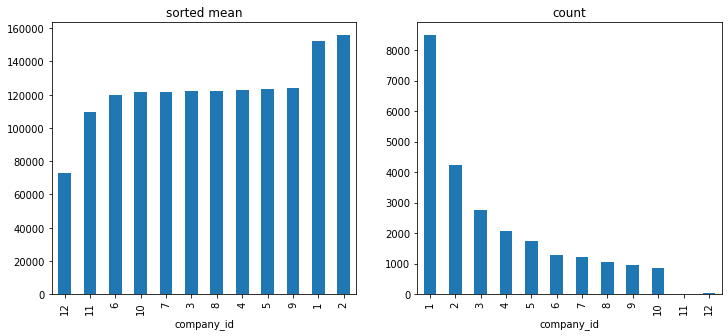

In [6]:
print(df.groupby('company_id')['salary'].mean().sort_values())
fig,ax = plt.subplots(1,2,figsize=(12,5))
df.groupby('company_id')['salary'].mean().sort_values().plot(kind='bar',ax=ax[0],title='sorted mean')
df.groupby('company_id')['salary'].count().plot(kind='bar',ax=ax[1],title='count')

dept
customer_service     82245.424837
marketing           135582.438408
sales               135912.358134
design              137460.869565
engineer            205531.439722
data_science        206885.893417
Name: salary, dtype: float64


<AxesSubplot:title={'center':'count'}, xlabel='dept'>

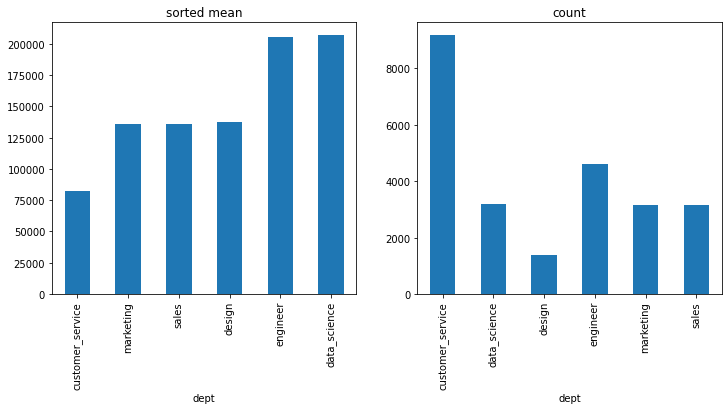

In [7]:
print(df.groupby('dept')['salary'].mean().sort_values())
fig,ax = plt.subplots(1,2,figsize=(12,5))
df.groupby('dept')['salary'].mean().sort_values().plot(kind='bar',ax=ax[0],title='sorted mean')
df.groupby('dept')['salary'].count().plot(kind='bar',ax=ax[1],title='count')

In [8]:
# create the [day,company_id,head_count] table
unique_date= pd.date_range(start='2011-01-23',end='2015-12-23',freq='D')
unique_date[:5]

DatetimeIndex(['2011-01-23', '2011-01-24', '2011-01-25', '2011-01-26',
               '2011-01-27'],
              dtype='datetime64[ns]', freq='D')

In [9]:
# created a table/dataframe with columns [day, employee_headcount, and company_id]
# iterative appending 

companies = sorted(df.company_id.unique())

day = []
company =[]
headcount=[]

for date in unique_date:
    for idx in companies:
        total_join = len(df[ (df['join_date']<=date) & (df['company_id']==idx)])
        total_quit = len(df[ (df['quit_date']<=date) & (df['company_id']==idx)])
        
        day.append(date)
        company.append(idx)
        headcount.append(total_join-total_quit)

new_table = pd.DataFrame({'day':day, 'company_id':company, 'employee_headcount':headcount})
new_table.head(5)
     
        

,day,company_id,employee_headcount
0,2011-01-23,1,0
1,2011-01-23,2,0
2,2011-01-23,3,0
3,2011-01-23,4,0
4,2011-01-23,5,0


In [10]:
# created a table/dataframe with columns [day, employee_headcount, and company_id]
# sql style join
companies_ids = pd.DataFrame({'company_id':sorted(pd.unique(df['company_id']))})
date_df = pd.DataFrame({'date':unique_date})
# Cartesian product pandas merge
companies_ids['key']=0
date_df['key']=0
merged= pd.merge(companies_ids,date_df,on='key')
merged

,company_id,key,date
0,1,0,2011-01-23
1,1,0,2011-01-24
2,1,0,2011-01-25
3,1,0,2011-01-26
4,1,0,2011-01-27
...,...,...,...
21547,12,0,2015-12-19
21548,12,0,2015-12-20
21549,12,0,2015-12-21
21550,12,0,2015-12-22


In [11]:
# EDA
# seperate data 
quit_data = df[~df['quit_date'].isnull()]
stay_data = df[df['quit_date'].isnull()]
display(quit_data.head(5))
display(stay_data.head(5))

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22
5,509529,4,data_science,14,165000.0,2012-01-30,2013-08-30


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
2,927315,4,marketing,14,101000.0,2014-10-13,NaT
6,88600,4,customer_service,21,107000.0,2013-10-21,NaT
7,716309,2,customer_service,4,30000.0,2014-03-05,NaT
9,504159,1,sales,7,104000.0,2012-06-12,NaT
11,904158,2,marketing,17,230000.0,2015-05-11,NaT


In [12]:
# employment length
emp_length = quit_data['quit_date']-quit_data['join_date']

In [13]:
days=[x.days for x in emp_length]
days[0:5]

[585, 340, 389, 1040, 578]

Text(0, 0.5, 'Frequency')

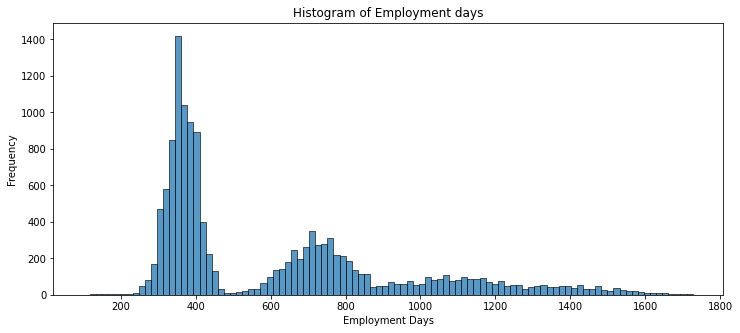

In [14]:
hist_kws = {'histtype':'bar','edgecolor':'black','alpha':0.5}
fig,ax = plt.subplots(figsize=(12,5))
sns.histplot(days,bins=100,kde=False,ax=ax)
ax.set_title('Histogram of Employment days')
ax.set_xlabel('Employment Days')
ax.set_ylabel('Frequency')

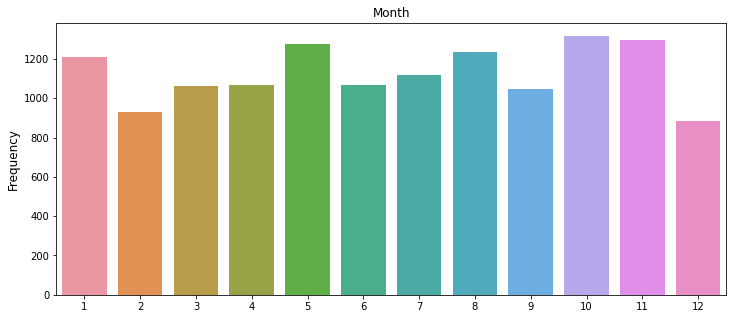

In [15]:
# Month and quiting
quit_month =  np.array(list(map(lambda x: x.month, quit_data['quit_date'])))

fig,ax =plt.subplots(figsize=(12,5))
sns.countplot(x=quit_month)
ax.set_title('Count plot of Quit Month',fontsize= 12)
ax.set_title('Month', fontsize=12)
ax.set_ylabel('Frequency',fontsize=12)
plt.show()


Text(0, 0.5, 'Count')

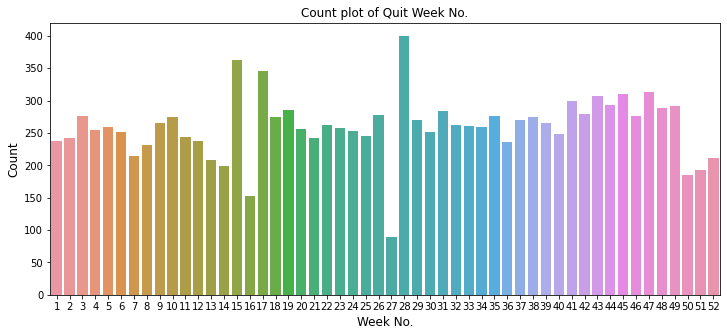

In [16]:
quit_week = [ x.week for x in quit_data['quit_date'] ]

fig,ax= plt.subplots(figsize=(12,5))
sns.countplot(x=quit_week,ax=ax)
ax.set_title('Count plot of Quit Week No.', fontsize=12)
ax.set_xlabel('Week No.',fontsize=12)
ax.set_ylabel('Count',fontsize=12)


In [17]:
# Machine Learning modeling
quit_data.loc[:,'work_days']=days
quit_data.loc[:,'quit_week']=quit_week
quit_data.head(5)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,work_days,quit_week
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585,44
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,340,14
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389,23
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040,34
5,509529,4,data_science,14,165000.0,2012-01-30,2013-08-30,578,35


In [18]:
# define early quit to be less than 13 months

stop_date = pd.to_datetime('2015-12-13')-pd.DateOffset(days=365+30)
subset = df[df['join_date']<stop_date] # join before 13 months ahead of end date 

# define stay
early_quit = subset['quit_date'].isnull()|(subset['quit_date']>subset['join_date']+pd.DateOffset(days=365+30))

# reverse 
subset['early_quit']=1 - early_quit.astype(int)
subset.head()


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,early_quit
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,1
2,927315,4,marketing,14,101000.0,2014-10-13,NaT,0
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,0


In [19]:
# one hot encoding
dummy_df = pd.get_dummies(subset,columns=['company_id','dept'])
dummy_df.head()
# drop join_date & quit_date
dummy_df.drop(['join_date','quit_date'],inplace=True,axis=1)

In [20]:
X = dummy_df.loc[:,dummy_df.columns!='early_quit']
y = dummy_df.loc[:,'early_quit']
display(X.shape)
display(y.shape)
train_X,test_X,train_y,test_y = train_test_split(X,y)

(19274, 21)

(19274,)

In [25]:
clf = DecisionTreeClassifier(max_depth = 3, min_samples_leaf=30,random_state=32)
y_hat=clf.fit(X=train_X,y=train_y).predict(test_X)

In [26]:
acc_score = accuracy_score(test_y,y_hat)
print(f'The accuracy score of the decision tree is:{ acc_score }')

The accuracy score of the decision tree is:0.7119734384727122


[Text(167.4, 190.26, 'X[2] <= 224500.0\ngini = 0.409\nsamples = 14455\nvalue = [10305, 4150]'),
 Text(83.7, 135.9, 'X[2] <= 75500.0\ngini = 0.425\nsamples = 12394\nvalue = [8593, 3801]'),
 Text(41.85, 81.53999999999999, 'X[1] <= 8.5\ngini = 0.384\nsamples = 3326\nvalue = [2464, 862]'),
 Text(20.925, 27.180000000000007, 'gini = 0.37\nsamples = 2453\nvalue = [1851, 602]'),
 Text(62.775000000000006, 27.180000000000007, 'gini = 0.418\nsamples = 873\nvalue = [613, 260]'),
 Text(125.55000000000001, 81.53999999999999, 'X[2] <= 169500.0\ngini = 0.438\nsamples = 9068\nvalue = [6129, 2939]'),
 Text(104.625, 27.180000000000007, 'gini = 0.447\nsamples = 6641\nvalue = [4403, 2238]'),
 Text(146.475, 27.180000000000007, 'gini = 0.411\nsamples = 2427\nvalue = [1726, 701]'),
 Text(251.10000000000002, 135.9, 'X[2] <= 274500.0\ngini = 0.281\nsamples = 2061\nvalue = [1712, 349]'),
 Text(209.25, 81.53999999999999, 'X[11] <= 0.5\ngini = 0.319\nsamples = 1054\nvalue = [844, 210]'),
 Text(188.32500000000002, 

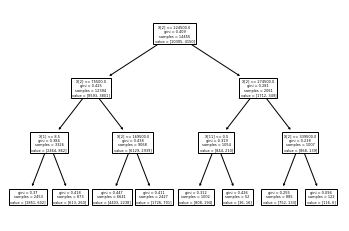

In [27]:
# visualize the tree
# Xcode issues 
'''
features = [ x for x in train_X.columns]
targets= ['No early_quit','Early_quit']
DOT = tree.export_graphviz(clf,feature_names=features,class_names=targets)
graph = graphviz.Source(DOT)
graph
'''
tree.plot_tree(clf)